# First 2 XGBOOST APPROACH WITH DATA RESCALED
# BUT NOT SMOOTHED

This is due to better empirical performences of the sets and visually. 
But using rolling3 smoothing dataset, and Optimizing better, we believe we would get better results.  

train_1min shape: (1963492, 4)
raw test shape: (361711, 3)
After dropna on fridge:
train shape: (1963488, 27)
X shape: (1963488, 24)
X_test shape: (361711, 24)
Number of distinct homes in train: 4
Using GroupKFold with n_splits = 4

Fold 1/4  (train: 831181, val: 1132307)
Fold 1 RMSE: 47.00585 | MAE: 35.81274

Fold 2/4  (train: 1625750, val: 337738)
Fold 2 RMSE: 40.28776 | MAE: 31.19875

Fold 3/4  (train: 1667413, val: 296075)
Fold 3 RMSE: 39.21084 | MAE: 26.88782

Fold 4/4  (train: 1766120, val: 197368)
Fold 4 RMSE: 53.86352 | MAE: 50.82210

Overall CV RMSE: 45.57266345819543
Overall CV MAE : 35.182027641424


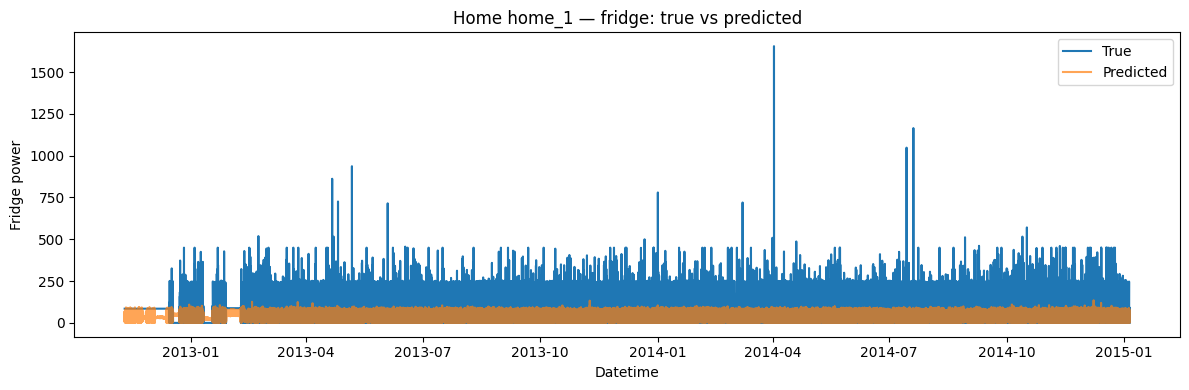

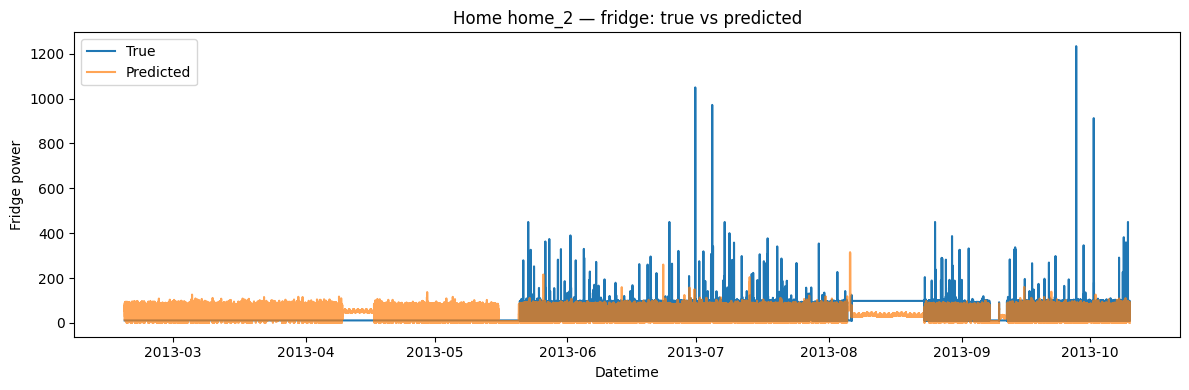

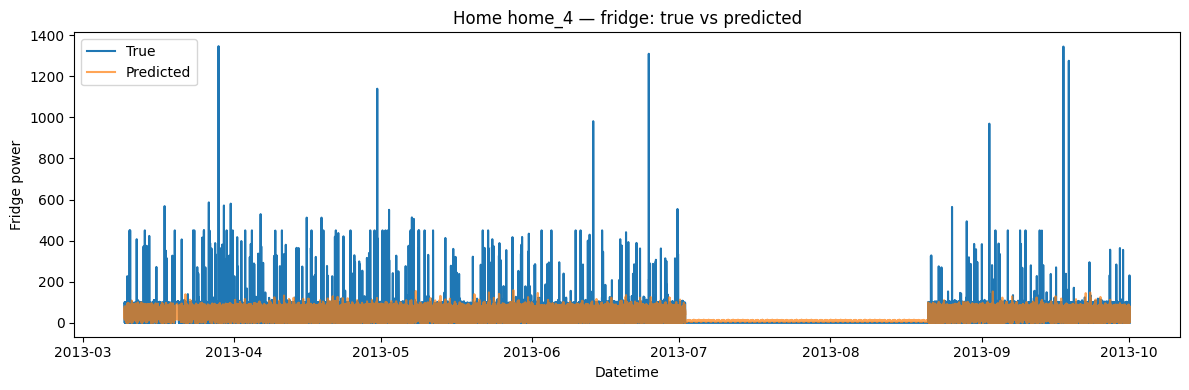

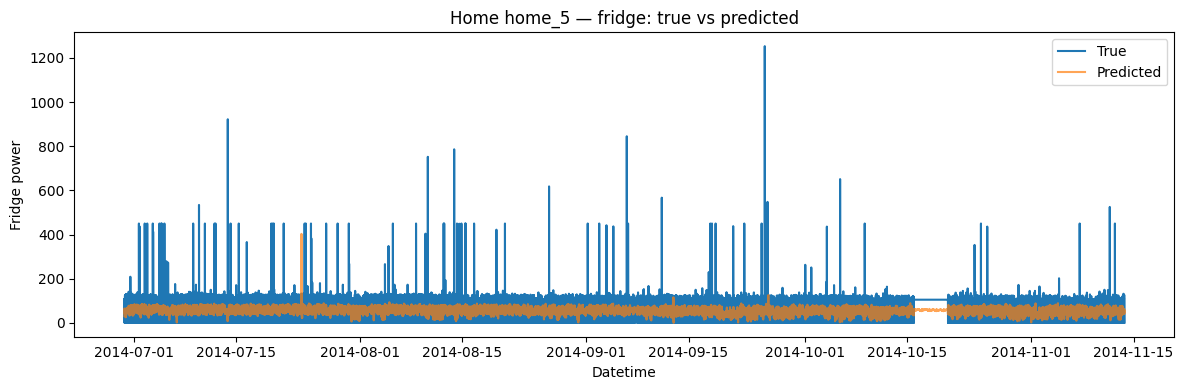


Predicting on test…
Saved submission to: ../../submission/submission_xgboost_final.csv


,id,fridge
0,0,71.513405
1,1,61.716114
2,2,64.338631
3,3,83.966354
4,4,80.167336


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas.api.types as ptypes
import matplotlib.pyplot as plt


train = pd.read_csv("../../data/processed/train_1min.csv")
test = pd.read_csv("../../data/raw/test.csv")   # raw Kaggle test

print("train_1min shape:", train.shape)
print("raw test shape:", test.shape)


def make_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # ensure datetime is parsed
    if not ptypes.is_datetime64_any_dtype(df["datetime"]):
        df["datetime"] = pd.to_datetime(df["datetime"], utc=True, errors="coerce")

    df["hour"] = df["datetime"].dt.hour
    df["minute"] = df["datetime"].dt.minute
    df["dayofweek"] = df["datetime"].dt.dayofweek

    return df

def make_window_features(df: pd.DataFrame, window: int = 20, is_train: bool = True) -> pd.DataFrame:

    df = df.copy()

    if "home_id" in df.columns:
        # sort by home + time
        df = df.sort_values(["home_id", "datetime"])
        group_power = df.groupby("home_id")["power"]

        for lag in range(1, window + 1):
            df[f"lag_{lag}"] = group_power.shift(lag)
    else:
        # no home_id → treat as one global sequence
        df = df.sort_values("datetime")
        for lag in range(1, window + 1):
            df[f"lag_{lag}"] = df["power"].shift(lag)

    # Fill initial NaNs with 0
    lag_cols = [f"lag_{lag}" for lag in range(1, window + 1)]
    df[lag_cols] = df[lag_cols].fillna(0)

    return df


train = make_features(train)
test = make_features(test)

train = make_window_features(train, window=20, is_train=True)
test = make_window_features(test, window=20, is_train=False)

# Drop rows where fridge label is missing (XGBoost doesn't accept NaN labels)
train = train.dropna(subset=["fridge"]).reset_index(drop=True)

print("After dropna on fridge:")
print("train shape:", train.shape)


FEATURES = ["power", "hour", "minute", "dayofweek"] + [f"lag_{lag}" for lag in range(1, 21)]

X = train[FEATURES].astype(np.float32)
y = train["fridge"].astype(float).values
X_test = test[FEATURES].astype(np.float32)

print("X shape:", X.shape)
print("X_test shape:", X_test.shape)

n_groups = train["home_id"].nunique()
print("Number of distinct homes in train:", n_groups)


models = []

if n_groups >= 2:
    n_splits = min(10, n_groups)
    print("Using GroupKFold with n_splits =", n_splits)

    gkf = GroupKFold(n_splits=n_splits)
    preds_oof = np.zeros(len(train), dtype=np.float32)

    for fold, (tr_idx, val_idx) in enumerate(gkf.split(X, y, groups=train["home_id"]), start=1):
        print(f"\nFold {fold}/{n_splits}  (train: {len(tr_idx)}, val: {len(val_idx)})")

        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]

        model = XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1,
        )

        model.fit(
            X_tr,
            y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False,
        )

        preds_val = model.predict(X_val)
        preds_val = np.clip(preds_val, 0.0, None)

        preds_oof[val_idx] = preds_val
        models.append(model)

        fold_rmse = np.sqrt(mean_squared_error(y_val, preds_val))
        fold_mae = mean_absolute_error(y_val, preds_val)
        print(f"Fold {fold} RMSE: {fold_rmse:.5f} | MAE: {fold_mae:.5f}")

    cv_rmse = np.sqrt(mean_squared_error(y, preds_oof))
    cv_mae = mean_absolute_error(y, preds_oof)
    print("\nOverall CV RMSE:", cv_rmse)
    print("Overall CV MAE :", cv_mae)

else:
    print("Only one home_id group found, training on full data without CV.")
    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
    )
    model.fit(X, y)
    models.append(model)
    preds_oof = model.predict(X)
    preds_oof = np.clip(preds_oof, 0.0, None)


train_viz = train.copy()
train_viz["pred_fridge"] = preds_oof

if "home_id" in train_viz.columns:
    homes = sorted(train_viz["home_id"].unique())
else:
    homes = [None]

for home in homes:
    if home is not None:
        df_plot = train_viz[train_viz["home_id"] == home].copy()
        title = f"Home {home} — fridge: true vs predicted"
    else:
        df_plot = train_viz.copy()
        title = "Fridge — true vs predicted"

    df_plot = df_plot.sort_values("datetime")

    plt.figure(figsize=(12, 4))
    plt.plot(df_plot["datetime"], df_plot["fridge"], label="True")
    plt.plot(df_plot["datetime"], df_plot["pred_fridge"], label="Predicted", alpha=0.7)
    plt.title(title)
    plt.xlabel("Datetime")
    plt.ylabel("Fridge power")
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nPredicting on test…")
test_preds_list = [m.predict(X_test) for m in models]
test_preds = np.mean(test_preds_list, axis=0)
test_preds = np.clip(test_preds, 0.0, None)

submission = pd.DataFrame({
    "id": test["id"],
    "fridge": test_preds,
})

out_path = "../../submission/submission_xgboost_final.csv"
submission.to_csv(out_path, index=False)
print("Saved submission to:", out_path)

submission.head()


Number of distinct homes in train: 4
Using GroupKFold with n_splits = 4
CV RMSE: 48.874306905958534
CV MAE: 39.851148550256944


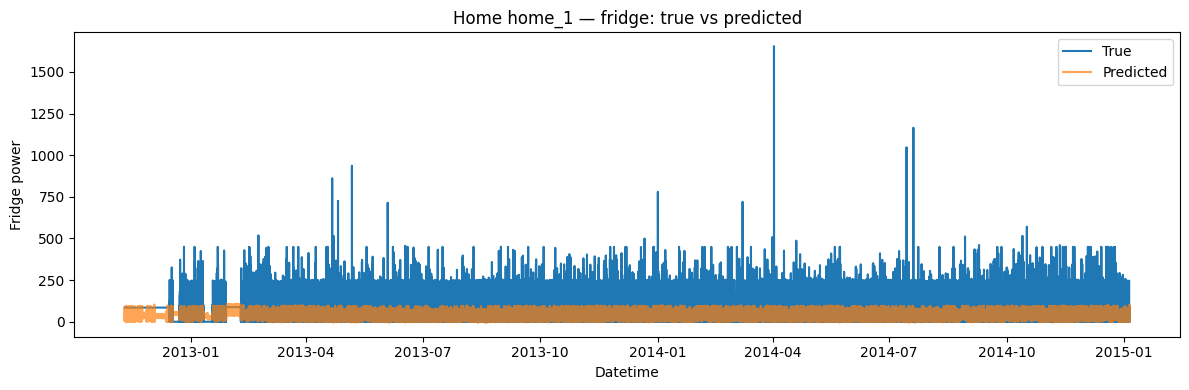

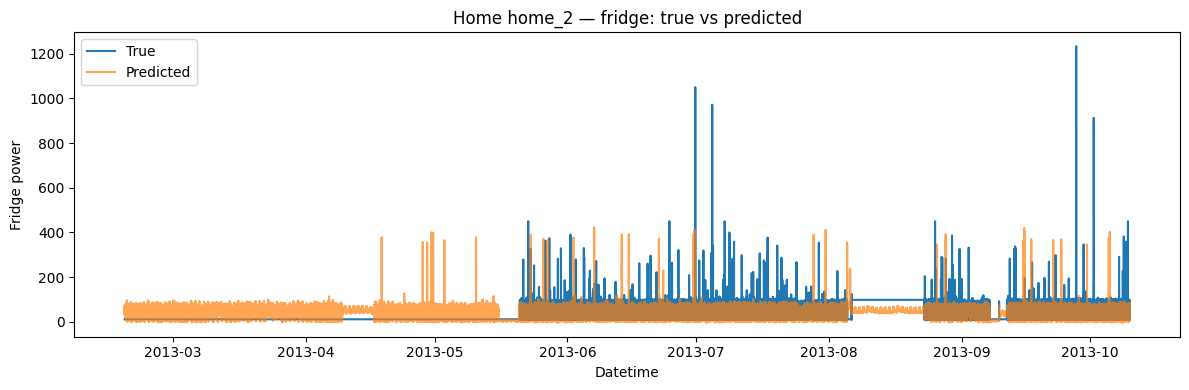

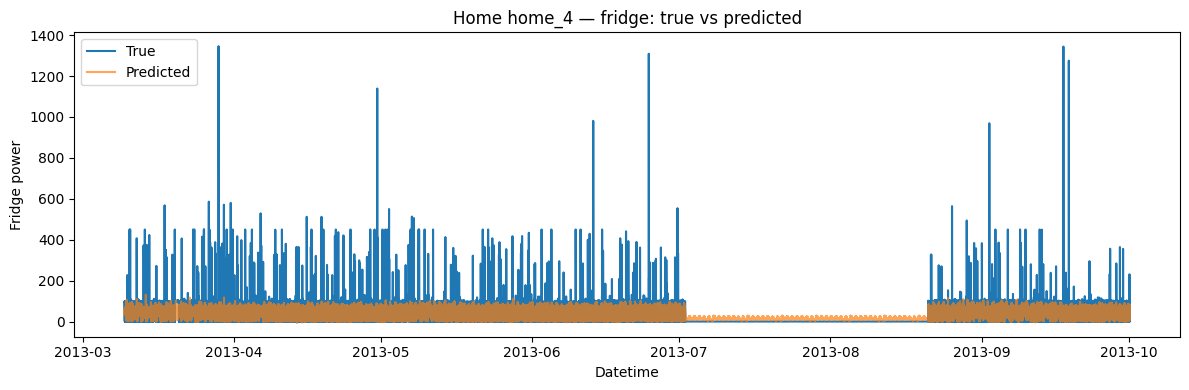

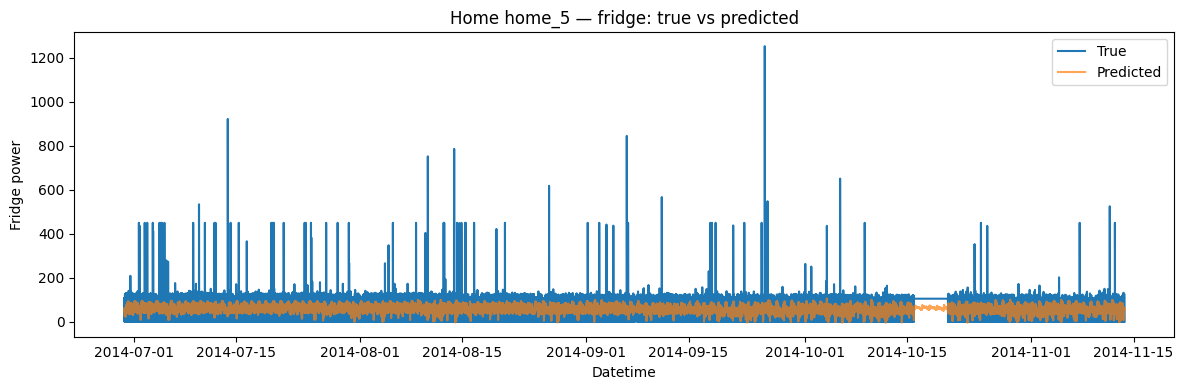

Saved submission to: ../../submission/submission_xgboostSmooth_final.csv


In [9]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pandas.api.types as ptypes


train = pd.read_csv("../../data/processed/train_1min.csv")
test = pd.read_csv("../../data/raw/test.csv")   # raw Kaggle test

# Remove rows with missing target or power
train = train.dropna(subset=["power", "fridge"])


def make_features(df):
    df = df.copy()

    # Ensure datetime is parsed
    if not ptypes.is_datetime64_any_dtype(df["datetime"]):
        df["datetime"] = pd.to_datetime(df["datetime"], utc=True, errors="coerce")

    df["hour"] = df["datetime"].dt.hour
    df["minute"] = df["datetime"].dt.minute
    df["dayofweek"] = df["datetime"].dt.dayofweek
    df["second"] = df["datetime"].dt.second

    # Is this a quarter-hour reading (00, 15, 30, 45 and second == 0)?
    df["is_quarter"] = ((df["minute"] % 15 == 0) & (df["second"] == 0)).astype(int)

    return df


def add_sequence_features_train(df):
    df = df.sort_values(["home_id", "datetime"]).copy()

    # previous power within each home
    df["prev_power"] = df.groupby("home_id")["power"].shift(1)

    # difference to previous measurement
    df["delta_power"] = df["power"] - df["prev_power"]

    # Fill NaNs for the first row of each group
    df[["prev_power", "delta_power"]] = df[["prev_power", "delta_power"]].fillna(0)

    return df


def add_sequence_features_test(df):
    # test is a single household → treat as one sequence
    df = df.sort_values("datetime").copy()

    df["prev_power"] = df["power"].shift(1)
    df["delta_power"] = df["power"] - df["prev_power"]
    df[["prev_power", "delta_power"]] = df[["prev_power", "delta_power"]].fillna(0)

    return df


# Apply feature engineering
train = make_features(train)
test = make_features(test)

train = add_sequence_features_train(train)
test = add_sequence_features_test(test)

# Features

FEATURES = [
    "power",
    "hour",
    "minute",
    "dayofweek",
    "is_quarter",
    "prev_power",
    "delta_power",
]

X = train[FEATURES]
y = train["fridge"]
X_test = test[FEATURES]


n_groups = train["home_id"].nunique()
print("Number of distinct homes in train:", n_groups)

models = []  # will store (model, scaler)

if n_groups >= 2:
    n_splits = min(5, n_groups)
    print("Using GroupKFold with n_splits =", n_splits)

    gkf = GroupKFold(n_splits=n_splits)
    preds_oof = np.zeros(len(train))

    for tr_idx, val_idx in gkf.split(X, y, groups=train["home_id"]):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        # --- Scaling per fold ---
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_val_scaled = scaler.transform(X_val)

        model = XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="reg:squarederror",
            random_state=42,
        )

        model.fit(
            X_tr_scaled, y_tr,
            eval_set=[(X_val_scaled, y_val)],
            verbose=False,
        )

        preds_oof[val_idx] = model.predict(X_val_scaled)
        models.append((model, scaler))  # store model + its scaler

    print("CV RMSE:", np.sqrt(mean_squared_error(y, preds_oof)))
    print("CV MAE:", mean_absolute_error(y, preds_oof))
else:
    # only one home_id available → just train one model on all data
    print("Only one group found, training on full data without CV.")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
    )
    model.fit(X_scaled, y)
    models.append((model, scaler))



# Plots 

train_viz = train.copy()
train_viz["pred_fridge"] = preds_oof

# If we have home_id, plot one time-series per house
if "home_id" in train_viz.columns:
    homes = sorted(train_viz["home_id"].unique())
else:
    homes = [None]

for home in homes:
    if home is not None:
        df_plot = train_viz[train_viz["home_id"] == home].copy()
        title = f"Home {home} — fridge: true vs predicted"
    else:
        df_plot = train_viz.copy()
        title = "Fridge — true vs predicted"

    # Sort by time so the curves make sense
    df_plot = df_plot.sort_values("datetime")

    plt.figure(figsize=(12, 4))
    plt.plot(df_plot["datetime"], df_plot["fridge"], label="True")
    plt.plot(df_plot["datetime"], df_plot["pred_fridge"], label="Predicted", alpha=0.7)
    plt.title(title)
    plt.xlabel("Datetime")
    plt.ylabel("Fridge power")
    plt.legend()
    plt.tight_layout()
    plt.show()


test_preds = np.mean(
    [m.predict(s.transform(X_test)) for (m, s) in models],
    axis=0
)


submission = pd.DataFrame({
    "id": test["id"],
    "fridge": test_preds
})

out_path = "../../submission/submission_xgboostSmooth_final.csv"
submission.to_csv(out_path, index=False)
print("Saved submission to:", out_path)


## Comments on the plots

Even tho we have a worst MAE on the CV, we have less overfitting on the plot. 
We can see mostly when the total_power is 0, in the previous plots it was still having the fridge in activity, now it's better. 
This is trying with the data not smoothed, so the train_1min.csv file 